DATA AUGMENTATION USING GANs

  This project leverages Generative Adversarial Networks (GANs) for image data augmentation to enhance training datasets. By generating realistic new images, the GAN improves model performance on tasks like classification. The GAN consists of a generator and a discriminator, trained adversarially to create high-quality augmented images

In [160]:

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras import Input,layers,Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random

In [161]:
def load_images_from_directory(directory, target_size=(150, 150)):
    data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    data_flow = data_gen.flow_from_directory(directory, target_size=target_size, batch_size=32, class_mode=None)
    
    data_list = []
    for i in range(data_flow.__len__()):
        try:
            data_batch = next(data_flow)
            data_list.append(data_batch)
            print(f"Loaded batch {i+1}/{data_flow.__len__()}")
        except Exception as e:
            print(f"Error loading batch {i+1}: {e}")
            break
    
    data = np.concatenate(data_list, axis=0)
    print(f"Total images loaded: {data.shape[0]}")
    return data

train_dir = "C:\\Users\\DELL\\Desktop\\aug\\train"
train_images = load_images_from_directory(train_dir)

Found 72 images belonging to 2 classes.


Loaded batch 1/3
Loaded batch 2/3
Loaded batch 3/3
Total images loaded: 72


DEFINE GENERATOR MODEL

In [162]:
def build_generator():
    input_layer = Input(shape=(100,))
    x = layers.Dense(128, activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(150 * 150 * 3, activation='tanh')(x)
    output_layer = layers.Reshape((150, 150, 3))(x)

    model = Model(input_layer, output_layer)
    return model

DEFINE DISCRIMINATOR MODEL

In [163]:
def build_discriminator():
    input_layer = Input(shape=(150, 150, 3))
    x = layers.Flatten()(input_layer)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x)

    model = Model(input_layer, output_layer)
    return model

COMPILE THE GAN

In [164]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = Model(gan_input, gan_output)
    return gan

generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(f"Generator trainable weights: {len(generator.trainable_weights)}")
print(f"Discriminator trainable weights: {len(discriminator.trainable_weights)}")

Generator trainable weights: 14
Discriminator trainable weights: 6


In [165]:
discriminator.trainable = True
gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')



TRAIN THE GAN

In [166]:
def train_step(generator, discriminator, gan, real_images, batch_size):
    noise = tf.random.normal([batch_size, 100])
    fake_images = generator(noise)
    
    labels_real = tf.ones((batch_size, 1))
    labels_fake = tf.zeros((batch_size, 1))
    
    # Train discriminator on real and fake images
    discriminator.trainable = True
    with tf.GradientTape() as d_tape:
        d_loss_real = discriminator.train_on_batch(real_images, labels_real)
        d_loss_fake = discriminator.train_on_batch(fake_images, labels_fake)
    discriminator.trainable = False
    
    # Train generator
    noise = tf.random.normal([batch_size, 100])
    labels_gan = tf.ones((batch_size, 1))
    with tf.GradientTape() as g_tape:
        g_loss = gan.train_on_batch(noise, labels_gan)
    
    return d_loss_real, d_loss_fake, g_loss

In [167]:
uploaded_image_path ="C:\\Users\\DELL\\Desktop\\aug\\dogs.png"
uploaded_image = load_img(uploaded_image_path)

x = img_to_array(uploaded_image)
x = np.expand_dims(x, axis=0)



In [168]:
def train_gan(generator, discriminator, gan, data, epochs=100, batch_size=16):  
    for epoch in range(epochs):
        idx = np.random.randint(0, data.shape[0], batch_size - 1)
        real_images = data[idx]
        
        # Add the uploaded image to the real images batch
        real_images = np.concatenate((real_images, uploaded_image_array), axis=0)
        
        d_loss_real, d_loss_fake, g_loss = train_step(generator, discriminator, gan, real_images, batch_size)
        
        if epoch % 10 == 0:  # Print progress more frequently
            print(f"Epoch {epoch}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")


GENERATE AND SAVE IMAGES

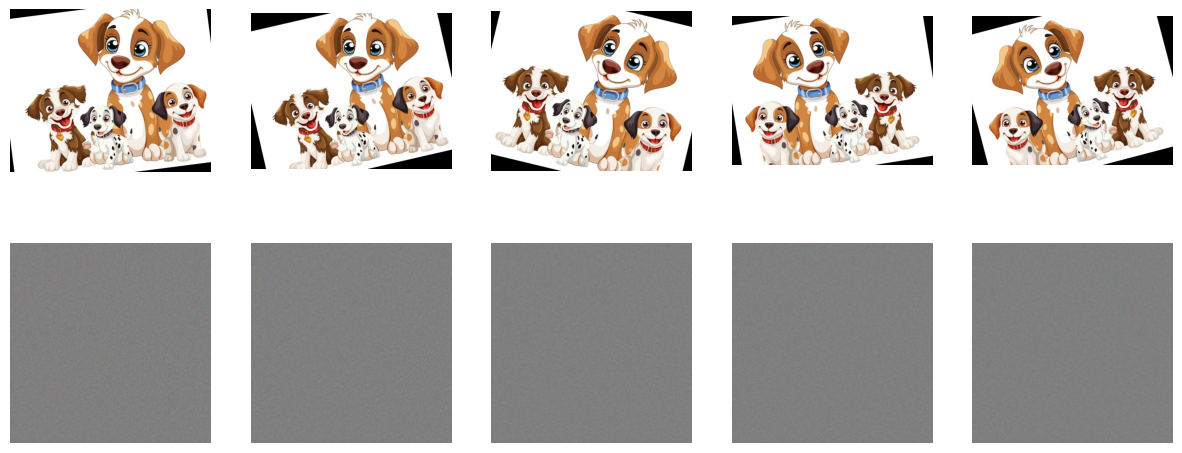

In [169]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i, img_path in enumerate(os.listdir(output_dir)[:10]):
    img = load_img(os.path.join(output_dir, img_path))
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].axis('off')
plt.show()

In [170]:
def generate_and_save_images(generator, num_images=5, save_dir='/mnt/data/augmented_images'):
    os.makedirs(save_dir, exist_ok=True)
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)

    for i in range(num_images):
        img = (generated_images[i] * 127.5 + 127.5).astype(np.uint8)
        plt.imsave(f"{save_dir}/augmented_image_{i+1}.png", img)

generate_and_save_images(generator)

augmented_image_dir = '/mnt/data/augmented_images'
augmented_image_files = os.listdir(augmented_image_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


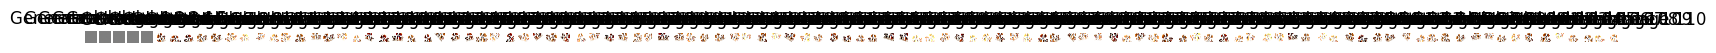

In [171]:
plt.figure(figsize=(20, 20))  # Increased figure size for better visibility
num_images = len(augmented_image_files)

# Plot the uploaded image first
plt.subplot(1, num_images + 1, 1)
plt.imshow(uploaded_image)
plt.title("Uploaded Image")
plt.axis('off')

# Plot the generated images
for i, img_file in enumerate(augmented_image_files):
    img = plt.imread(os.path.join(augmented_image_dir, img_file))
    plt.subplot(1, num_images + 1, i + 1)  # Adjusted to accommodate the uploaded image
    plt.imshow(img)
    plt.title(f"Generated Image {i+1}")
    plt.axis('off')

plt.show()